In [1]:
%run startup.py

In [2]:
# plt.style.use('default')
plt.style.use('seaborn')
# plt.style.use('bmh')
# plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

### 0. Read the data

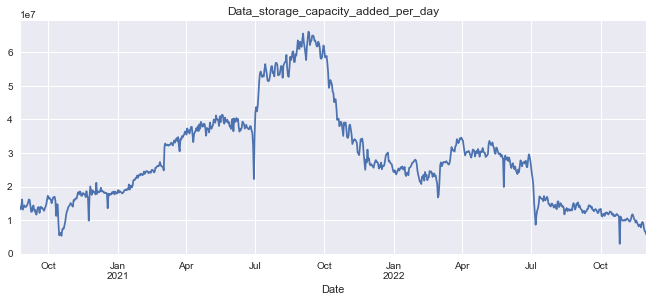

In [3]:
df = pd.read_csv('data/FilecoinGreenEnergyNew.csv')

df['Date'] = pd.to_datetime(df.Date)
df['year']  = df.Date.map(lambda x: str(x)[:4])
df['quarter'] = df.year.astype(str) + 'Q' + df.Date.dt.quarter.astype(str).values
df['month'] = df.Date.map(lambda x: str(x)[:7])
df.set_index('Date', inplace = True)

feats = [
 'Data_storage_capacity_added_per_day',
 'Energy_consumption_rate_estimate_bound',
 'Energy_intensity_estimate_bound',
 'FIL_Close',
 'FIL_Volume',
]
feat = 'Data_storage_capacity_added_per_day'
_ = df[feat].plot(figsize = (10,4), title = feat)

### 1. Make predictions

In [4]:
from prophet import Prophet

# evaluation metric
def metric_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# prepare dataframe
x = df[feat]
x = x.reset_index()
x.columns = ['ds','y']

# build models (2 years of data, 1 year, 6 months +  different seasonality)
models = [
    'prophet2years_all',
    'prophet2years',
    'prophet1years_all',
    'prophet1years',
    'prophet6months_all',
    'prophet6months',
]
i = -1

y = x[-91:].set_index('ds').y
dict_preds = {}
dict_evals = {}
dict_out = {}
for x1 in [x, x[-365:], x[-182:]]:
    for flg in [True, False]:
        i += 1
        modelname = models[i]
        # train
        m = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=flg,)
        m.fit(x1)

        # predict
        t1 = 31
        df1 = m.make_future_dataframe(periods=t1, freq='d')
        df_out = m.predict(df1)
        dict_out[modelname] = df_out
        
        y_pred = df_out.set_index('ds')['yhat']
        dict_preds[modelname] = y_pred
        dict_evals[modelname] = metric_mape(y, y_pred.loc[y.index])

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


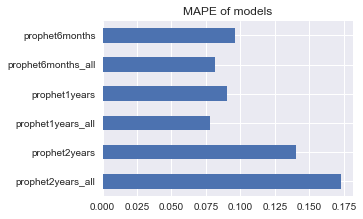

In [5]:
_ = pd.Series(dict_evals).plot(kind = 'barh', figsize = (4,3), title = 'MAPE of models')

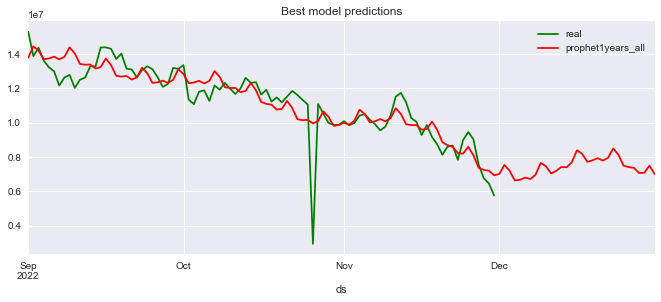

In [6]:
# plotting
df1 = pd.DataFrame(dict_preds).iloc[-122:,:]
df1['real'] = y
model_best = 'prophet1years_all'

feats = ['real',model_best]
_ = df1[feats].plot(figsize = (10,4), title = 'Best model predictions', color = ['green','red'])

### 2. Model description

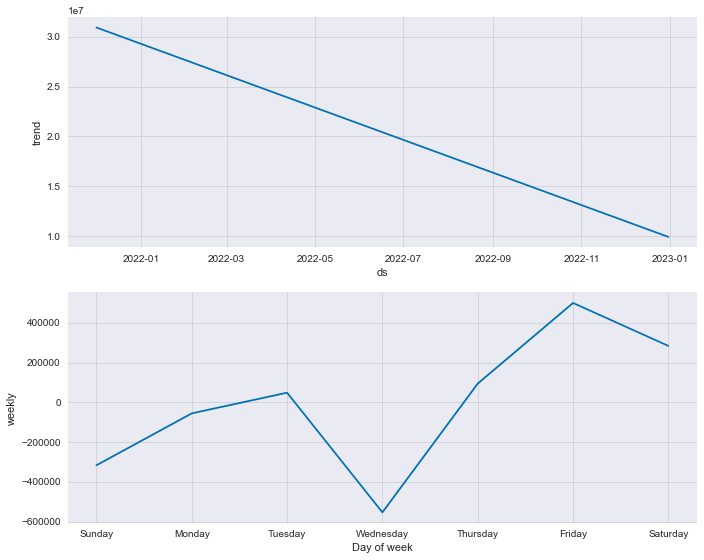

In [7]:
df_out = dict_out[model_best]
m.plot_components(df_out, figsize = (10,8))
plt.show()